In [1000]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re

In [1001]:
#some cheezy GLOBAL VARIABLES HERE (don't kill me Daniel!)
# this cell needs adjustments from run to run, depending which files one wants to investigate

file_number_signal = 2 #the file number corresponding to a scan (from Elettra logbook!)

file_number_dark_20nA = 4
file_number_dark_200pA = 5
file_number_photodiode = 14
file_number_photodiode_200pA_200pA = 17 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively
file_number_photodiode_20nA_200pA = 16 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively
file_number_photodiode_200nA_20nA = 15 #dark photodiode current file number, with Kiethley-B and Kiethley-A sensitivity values, respectively

regs_per_sample = 7 #number of regions per sample (7 pretty much all the time)
region_sensitivities = ["200pA", "200pA", "200pA", "200pA", "200pA", "20nA", "20nA"] #an ordered list with sample signal (current) sensitivities of photon energy regions!
PD_region_sensitivities = ["200pA_200pA", "200pA_200pA", "200pA_200pA", "200pA_200pA", "20nA_200pA", "200nA_20nA", "200nA_20nA"] #same but for photodiode (KB and KA had different readings)

#from the following, only one list of materials needs to be used (sample holder 1 or 2)
materials = ['Aerodag_55', 'Graphite_55', 'ITO_MLI', 'ITO_Radiator'] #materials on sample plate 1, ordered as they were investigated!
#materials = ['Cu_tape', 'Au', 'ITO_MLI#1', 'ITO_MLI#2', 'Ag', 'fake_dust'] #materials on sample plate 2, ordered as they were investigated!

eV = 1.602e-19 #C, elementary charge
delta_I_by_I = 0.02 #relative error of all current readings is cca 2%
R_err = 0.05 #relative error (in %) of the Photodiode Responsivity (actually not given - this is just my guess)
use_BPM_region_indexes = [] #indexes of regions in which normalization by BPM (rather than by monitor) should be used

In [1002]:
#This function simply reads a BEAR output text file with data and outputs it as 
def read_file(filename):
    #just declaring a list for each column
    rel_t = [] #msec
    phot_E = [] #eV
    x = [] # Var_1, x spot position
    y = [] #Var_2, y spot position
    I_sample = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_monitor = [] # INSTR_2, Kiethley A, instrument 2 - monitor
    I_BPM_sum = [] #sum of BPM current measurements

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of a long line
            if "______________________________________________" in l:
                break
        for l in myfile: #read the file until the occurence of this long line
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        rel_t.append(line[0])
        phot_E.append(line[1])
        x.append(line[2])
        y.append(line[3])
        I_sample.append(line[4])
        I_monitor.append(line[5])
        I_BPM_sum.append(line[7])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(rel_t)):
        rel_t[i] = float(rel_t[i])
        phot_E[i] = float(phot_E[i])
        x[i] = float(x[i])
        y[i] = float(y[i])
        I_sample[i] = float(I_sample[i])
        I_monitor[i] = float(I_monitor[i])
        I_BPM_sum[i] = float(I_BPM_sum[i])
    
    return([rel_t, phot_E, x, y, I_sample, I_monitor, I_BPM_sum])

In [1003]:
def get_region_df(reg_filename, reg_number, material_name):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'rel_t': reg[0], 'phot_E': reg[1], 'x': reg[2], 'y': reg[3], 'I_sample': reg[4], 'I_monitor' : reg[5], 'I_BPM_sum': reg[6], 'reg_number': reg_number, 'material_name': material_name}
    reg_df = pd.DataFrame(data=reg_data)
    return(reg_df)

In [1004]:
def concate_data(materials, regs_per_sample, file_number):
#A function that concates dataframes from all regions into a large dataframe
    
    if "dark" in materials[0]: #for dark offsets, we use a single file, not regionwise --> different filename
        df = get_region_df(f"/Users/sebastiankalos/Documents/Moondust/Elettra_data/20210802_arneodo/file(1)" + "{:04d}".format(file_number) + ".txt", 0, "no material (dark)")
        return(df)
    else:
        all_run_regions = []
        for j in range(0,len(materials)): #for each material
            material_name = materials[j] #copy name of the material
            
            for i in range(regs_per_sample * j + 1, regs_per_sample * (j+1) +1): #for each region corresponding to this material (note the region numering!)
                
                #read the corresponding textfile and extract its data into a dataframe using a function defined above
                if "photodiode" in material_name: #for photodiode readings
                    append_this = get_region_df(f"/Users/sebastiankalos/Documents/Moondust/Elettra_data/20210802_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",i, material_name)
                    all_run_regions.append(append_this)

                else: #for normal signal readings
                    append_this = get_region_df(f"/Users/sebastiankalos/Documents/Moondust/Elettra_data/20210802_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",i, material_name) 
                    all_run_regions.append(append_this) #append the dataframe to others

        df = pd.concat(all_run_regions, ignore_index=True, sort=False) #combine all region and material dataframes into a single large one, without sorting (done separately later)
    return(df)

In [1005]:
#create signal dataframes:
df_signal = concate_data(materials, regs_per_sample, file_number_signal)

#create dark signal dataframes:
df_dark_20nA = concate_data(["dark"], regs_per_sample, file_number_dark_20nA)
df_dark_200pA = concate_data(["dark"], regs_per_sample, file_number_dark_200pA)

# create photodiode signal dataframe
df_photodiode = concate_data(["photodiode"], regs_per_sample, file_number_photodiode)

# get photodiode dark signal dataframes (for different sensitivity settings)
df_photodiode_dark_200pA_200pA = concate_data(["dark"], regs_per_sample, file_number_photodiode_200pA_200pA)
df_photodiode_dark_20nA_200pA = concate_data(["dark"], regs_per_sample, file_number_photodiode_20nA_200pA)
df_photodiode_dark_200nA_20nA = concate_data(["dark"], regs_per_sample, file_number_photodiode_200nA_20nA)

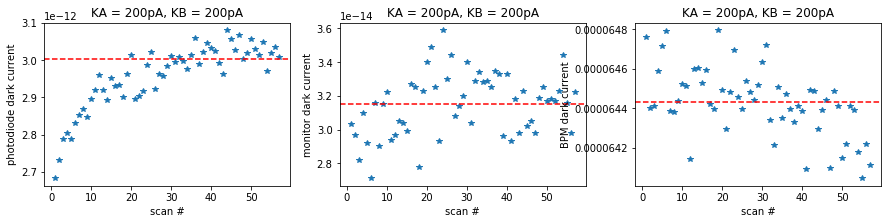

In [1006]:
#photodiode dark offsets: KB 200pA, KA 200pA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_sample'], '*')
plt2.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_200pA_200pA['phot_E'], df_photodiode_dark_200pA_200pA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current')
plt2.set_ylabel('monitor dark current')
plt3.set_ylabel('BPM dark current')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 200pA, KB = 200pA')
plt2.set_title('KA = 200pA, KB = 200pA')
plt3.set_title('KA = 200pA, KB = 200pA')

whole_bit = df_photodiode_dark_200pA_200pA['I_sample'].tolist()
last_bit = whole_bit[int(len(whole_bit)/3):]
PD_200pA_200pA_I_sample_offset = sum(last_bit)/len(last_bit)
plt1.axhline(y=PD_200pA_200pA_I_sample_offset, color='r', linestyle='--', label="taken offset")

PD_200pA_200pA_I_monitor_offset = sum(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())/len(df_photodiode_dark_200pA_200pA['I_monitor'].tolist())
plt2.axhline(y=PD_200pA_200pA_I_monitor_offset, color='r', linestyle='--', label="avg")

PD_200pA_200pA_I_BPM_offset = sum(df_photodiode_dark_200pA_200pA['I_BPM_sum'].tolist())/len(df_photodiode_dark_200pA_200pA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_200pA_200pA_I_BPM_offset, color='r', linestyle='--', label="avg")

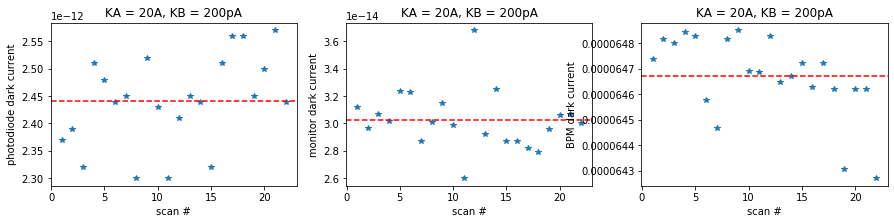

In [1007]:
#photodiode dark offsets: KB 20nA, KA 200pA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_sample'], '*')
plt2.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_20nA_200pA['phot_E'], df_photodiode_dark_20nA_200pA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current')
plt2.set_ylabel('monitor dark current')
plt3.set_ylabel('BPM dark current')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 20A, KB = 200pA')
plt2.set_title('KA = 20A, KB = 200pA')
plt3.set_title('KA = 20A, KB = 200pA')

PD_20nA_200pA_I_sample_offset = sum(df_photodiode_dark_20nA_200pA['I_sample'].tolist())/len(df_photodiode_dark_20nA_200pA['I_sample'].tolist())
plt1.axhline(y=PD_20nA_200pA_I_sample_offset, color='r', linestyle='--', label="taken offset")

PD_20nA_200pA_I_monitor_offset = sum(df_photodiode_dark_20nA_200pA['I_monitor'].tolist())/len(df_photodiode_dark_20nA_200pA['I_monitor'].tolist())
plt2.axhline(y=PD_20nA_200pA_I_monitor_offset, color='r', linestyle='--', label="avg")

PD_20nA_200pA_I_BPM_offset = sum(df_photodiode_dark_20nA_200pA['I_BPM_sum'].tolist())/len(df_photodiode_dark_20nA_200pA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_20nA_200pA_I_BPM_offset, color='r', linestyle='--', label="avg")

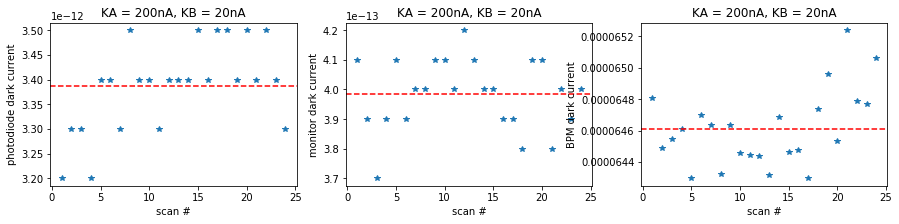

In [1008]:
#photodiode dark offsets: KB 200nA, KA 20nA
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 3)) #initialize a double plot
plt1.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_sample'], '*')
plt2.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_monitor'], '*')
plt3.plot(df_photodiode_dark_200nA_20nA['phot_E'], df_photodiode_dark_200nA_20nA['I_BPM_sum'], '*')
plt1.set_ylabel('photodiode dark current')
plt2.set_ylabel('monitor dark current')
plt3.set_ylabel('BPM dark current')
plt1.set_xlabel('scan #')
plt2.set_xlabel('scan #')
plt3.set_xlabel('scan #')
plt1.set_title('KA = 200nA, KB = 20nA')
plt2.set_title('KA = 200nA, KB = 20nA')
plt3.set_title('KA = 200nA, KB = 20nA')


PD_200nA_20nA_I_sample_offset = sum(df_photodiode_dark_200nA_20nA['I_sample'].tolist())/len(df_photodiode_dark_200nA_20nA['I_sample'].tolist())
plt1.axhline(y=PD_200nA_20nA_I_sample_offset, color='r', linestyle='--', label="taken offset")

PD_200nA_20nA_I_monitor_offset = sum(df_photodiode_dark_200nA_20nA['I_monitor'].tolist())/len(df_photodiode_dark_200nA_20nA['I_monitor'].tolist())
plt2.axhline(y=PD_200nA_20nA_I_monitor_offset, color='r', linestyle='--', label="avg")

PD_200nA_20nA_I_BPM_offset = sum(df_photodiode_dark_200nA_20nA['I_BPM_sum'].tolist())/len(df_photodiode_dark_200nA_20nA['I_BPM_sum'].tolist())
plt3.axhline(y=PD_200nA_20nA_I_BPM_offset, color='r', linestyle='--', label="avg")

In [1009]:
# dark sample current offsets:

##########
#sample dark current:
sample_I_dark_20nA = df_dark_20nA['I_sample'].tolist()
sample_I_dark_20nA_offset = sum(sample_I_dark_20nA)/len(sample_I_dark_20nA) 

sample_I_dark_200pA = df_dark_200pA['I_sample'].tolist()
sample_I_dark_200pA_offset = sum(sample_I_dark_200pA)/len(sample_I_dark_200pA) 

##########
#monitor dark current:
monitor_I_dark_20nA = df_dark_20nA['I_monitor'].tolist()
monitor_I_dark_20nA_offset = sum(monitor_I_dark_20nA)/len(monitor_I_dark_20nA)

monitor_I_dark_200pA = df_dark_200pA['I_monitor'].tolist()
monitor_I_dark_200pA_offset = sum(monitor_I_dark_200pA)/len(monitor_I_dark_200pA)

##########
#BPM dark current:
I_BPM_dark_20nA = df_dark_20nA['I_BPM_sum'].tolist()
I_BPM_dark_20nA_offset = sum(I_BPM_dark_20nA)/len(I_BPM_dark_20nA)

I_BPM_dark_200pA = df_dark_200pA['I_BPM_sum'].tolist()
I_BPM_dark_200pA_offset = sum(I_BPM_dark_200pA)/len(I_BPM_dark_200pA)


In [1010]:
def extract_reg(material_name, reg_number, df, I_sample_offset, I_monitor_offset, I_BPM_offset, rel_err): #function to extract plotting values for a specific material and region, 

    criterion1 = df['material_name'] == material_name
    criterion2 = df['reg_number'] == reg_number
    material_df = df.loc[criterion1 & criterion2]
    
    sample_I = material_df['I_sample'].tolist()
    monitor_I = material_df['I_monitor'].tolist()
    phot_E = material_df['phot_E'].tolist()
    I_BPM = material_df['I_BPM_sum'].tolist()

    #subtract offsets:
    sample_I = [val - I_sample_offset for val in sample_I]
    monitor_I = [val - I_monitor_offset for val in monitor_I]
    I_BPM = [val - I_BPM_offset for val in I_BPM]

    sample_I_err = [val * rel_err for val in sample_I]
    monitor_I_err = [val * rel_err for val in monitor_I]
    I_BPM_err = [val * rel_err for val in I_BPM]

    #normalize
    norm_I_byMonit = [i / j for i, j in zip(sample_I, monitor_I)]
    norm_I_byBPM = [i / j for i, j in zip(sample_I, I_BPM)]

    #calculate error for normalized current values:
    norm_I_byMonit_err = [np.sqrt((dIs/Im)**2 + (Is*dIm/(Im**2))**2) for dIs,Im,Is,dIm in zip(sample_I_err,monitor_I,sample_I,monitor_I_err)]
    norm_I_byBPM_err = [np.sqrt((dIs/Ibpm)**2 + (Is*dIbpm/(Ibpm**2))**2) for dIs,Ibpm,Is,dIbpm in zip(sample_I_err,I_BPM,sample_I,I_BPM_err)]

    return([sample_I, monitor_I, phot_E, I_BPM, norm_I_byMonit, norm_I_byBPM, sample_I_err, monitor_I_err, I_BPM_err, norm_I_byMonit_err, norm_I_byBPM_err])

#The following  needs some explanation. There are several materials, each with numerous regions (that need separate plotting due to normalization), 
#and each region contains multiple lists with different kinds of data (currents, photon energy, etc.)
#to avoid cluttering the code with variables, everything is put into a master-list of multiple dimensions (4, I guess)
#data is then accessed and plotted with simple indexing

In [1011]:
MATERIALS = [] #Master multi-dimension list

count = 1
for material_name in materials: #for each material name in the list (among globals!)
    MAT = []
    for i in range(count, count+regs_per_sample):
        if region_sensitivities[count % regs_per_sample] == "20nA":
            MAT.append(extract_reg(material_name, i, df_signal, sample_I_dark_20nA_offset, monitor_I_dark_20nA_offset, I_BPM_dark_20nA_offset, delta_I_by_I))
        elif region_sensitivities[count % regs_per_sample] == "200pA":
            MAT.append(extract_reg(material_name, i, df_signal, sample_I_dark_200pA_offset, monitor_I_dark_200pA_offset, I_BPM_dark_200pA_offset, delta_I_by_I))
    MATERIALS.append(MAT)
    count += regs_per_sample


(0, 6.944200275552309)

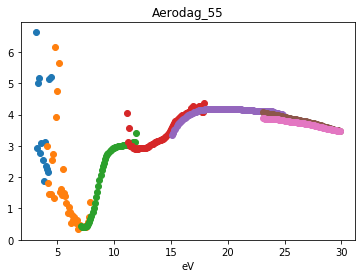

In [1012]:
marker = 'o'

# plot options for xvals and yvals:
# 0 --> sample_I
# 1 --> monitor_I
# 2 --> phot_E
# 3 --> I_BPM
# 4 --> norm_I_byMonit
# 5 --> norm_I_byBPM
# 6 --> sample_I error (absolute)
# 7 --> moitor_I error (absolute)
# 8 --> I_BPM error (absolute)
# 9 --> norm_I_byMonit error (absolute)
# 10 --> norm_I_byBPM error (absolute)

x_choice = 2
y_choice = 4

material_index = 0

for region_index in range(0, regs_per_sample):
    plt.plot(MATERIALS[material_index][region_index][x_choice], MATERIALS[material_index][region_index][y_choice], marker)
    plt.title(materials[material_index])

plt.xlabel('eV')
plt.gca().set_ylim(bottom=0)
#plt.gca().set_ylim(top=5)


In [1013]:
def convert_eV_to_wavelength(energy_eV_list):
    eV = 1.602*10e-19 #Joule
    h = 6.62607004*10e-34 #J*s
    c = 3*10e8 #m/s'
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J/(10e-9)) #in nm
    return(wavelength_list)

In [1014]:
#Work function values extrapolated from Modena measurements
ITO_WF = 3.95 #eV
Graphite_WF = 4.21 #eV
Aerodag_WF = 3.45

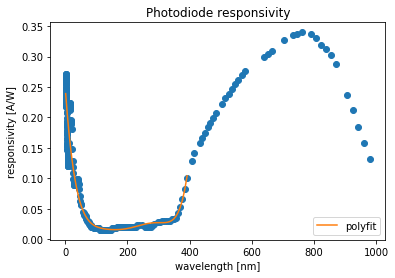

In [1015]:
# load photodiode responsivity from a textfile:
lambda_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "/Users/sebastiankalos/Documents/Moondust/Elettra_data/sxuv_responsivity.txt"
startline = 3

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    lambda_nm.append(line[0])
    responsivity.append(line[1])

    #extracted values are still strings --> cast numbers to floats
for i in range(0, len(lambda_nm)):
    lambda_nm[i] = float(lambda_nm[i])
    responsivity[i] = float(responsivity[i])

plt.plot(lambda_nm, responsivity, 'o')
plt.xlabel('wavelength [nm]')
plt.ylabel('responsivity [A/W]')
plt.title('Photodiode responsivity')

lambda_nm_2 = [i for i in lambda_nm if i <= 400]
responsivity_2 = responsivity[:len(lambda_nm_2)]

responsivity_fit = np.poly1d(np.polyfit(lambda_nm_2, responsivity_2, 6))
plt.plot(lambda_nm_2, responsivity_fit(lambda_nm_2), '-', label="polyfit")
plt.legend(loc="lower right")


In [1016]:

PD_I_monitor_offset = 0
PD_current_offset = 0
PD_BPM_I_offset = 0

#dark currents in photodiode measurements were not constant, rather increasing initially and then plateuing --> need to do a fit
PHOTODIODE = [] #master list for the Photodiode data
SECOND_FRAC = []
SECOND_FRAC_ERR = []
FACTOR = []
FACTOR_ERR = []

for i in range(1, regs_per_sample+1): #for each region
    if PD_region_sensitivities[i-1] == "200pA_200pA":
        PD_I_monitor_offset = PD_200pA_200pA_I_monitor_offset
        PD_current_offset = PD_200pA_200pA_I_sample_offset
        PD_BPM_I_offset = PD_200pA_200pA_I_BPM_offset 
    
    elif PD_region_sensitivities[i-1] == "20nA_200pA":
        PD_I_monitor_offset = PD_20nA_200pA_I_monitor_offset
        PD_current_offset = PD_20nA_200pA_I_sample_offset
        PD_BPM_I_offset = PD_20nA_200pA_I_BPM_offset

    elif PD_region_sensitivities[i-1] == "200nA_20nA":
        PD_I_monitor_offset = PD_200nA_20nA_I_monitor_offset
        PD_current_offset = PD_200nA_20nA_I_sample_offset
        PD_BPM_I_offset = PD_200nA_20nA_I_BPM_offset
    
    else: print("DID NOT FIND PD OFFSET!")

    #print(PD_I_monitor_offset,PD_current_offset,PD_BPM_I_offset)
    
    [PD_sample_I, PD_monitor_I, PD_phot_E, PD_I_BPM, PD_norm_I_byMonit, PD_norm_I_byBPM, PD_sample_I_err, PD_monitor_I_err, PD_I_BPM_err, PD_norm_I_byMonit_err, PD_norm_I_byBPM_err] = extract_reg("photodiode", i, df_photodiode, PD_current_offset, PD_I_monitor_offset, PD_BPM_I_offset, delta_I_by_I)
    PHOTODIODE.append([PD_sample_I, PD_monitor_I, PD_phot_E, PD_I_BPM, PD_norm_I_byMonit, PD_norm_I_byBPM, PD_sample_I_err, PD_monitor_I_err, PD_I_BPM_err, PD_norm_I_byBPM_err, PD_norm_I_byBPM])

    if i in use_BPM_region_indexes:
        second_fraction = [1 / val for val in PD_norm_I_byBPM]
        second_fraction_err = [dX / (X**2) for X,dX in zip(PD_norm_I_byBPM, PD_norm_I_byBPM_err)]
    else:
        second_fraction = [1 / val for val in PD_norm_I_byMonit]
        second_fraction_err = [dX / (X**2) for X,dX in zip(PD_norm_I_byMonit, PD_norm_I_byMonit_err)]

    SECOND_FRAC.append(second_fraction)
    SECOND_FRAC_ERR.append(second_fraction_err)
    
    R = responsivity_fit(PD_phot_E)
    factor = [i * j for i,j in zip(R, PD_phot_E)]
    factor_err = [R_err * val for val in factor]
    FACTOR.append(factor)
    FACTOR_ERR.append(factor_err)


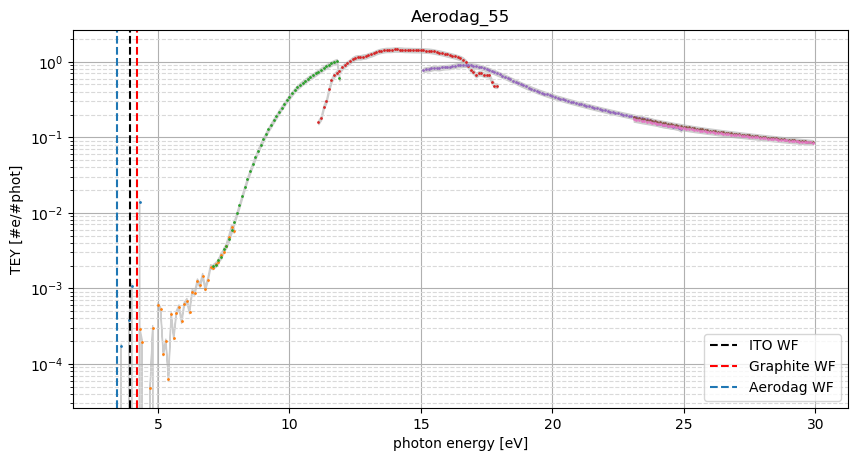

In [1017]:
figure(figsize=(10, 5), dpi=100)

material_index = 0

for region_index in range(0, regs_per_sample):
    if region_index in use_BPM_region_indexes:
        FIRST_FRAC = MATERIALS[material_index][region_index][5]
        FIRST_FRAC_ERR = MATERIALS[material_index][region_index][10]

    else:
        FIRST_FRAC = MATERIALS[material_index][region_index][4]
        FIRST_FRAC_ERR = MATERIALS[material_index][region_index][9]

    TEY_reg = [i * j * k for i,j,k in zip(FIRST_FRAC, SECOND_FRAC[region_index], FACTOR[region_index])]
    TEY_reg_err = [np.sqrt((dF1*F2*F3)**2 + (F1*dF2*F3)**2 + (F1*F2*dF3)**2) for F1,F2,F3,dF1,dF2,dF3 in zip(FIRST_FRAC,SECOND_FRAC[region_index],FACTOR[region_index],FIRST_FRAC_ERR, SECOND_FRAC_ERR[region_index],FACTOR_ERR[region_index])]

    phot_E_reg = MATERIALS[material_index][region_index][2]

    plt.fill_between(phot_E_reg, [i-j for i,j in zip(TEY_reg,TEY_reg_err)], [i+j for i,j in zip(TEY_reg,TEY_reg_err)], color='0.8')
    plt.plot(phot_E_reg, TEY_reg, marker, markersize=1)
    
plt.yscale('log')
plt.title(materials[material_index])

plt.xlabel('photon energy [eV]')
plt.ylabel('TEY [#e/#phot]')
plt.grid(linestyle='--')
plt.grid(which = 'major', linestyle='-')
plt.grid(which = 'minor', linestyle='--', color='0.85')


plt.axvline(x=ITO_WF, color='k', linestyle='--', label="ITO WF")
plt.axvline(x=Graphite_WF, color='r', linestyle='--', label="Graphite WF")
plt.axvline(x=Aerodag_WF, linestyle='--', label="Aerodag WF")
plt.legend(loc="lower right")

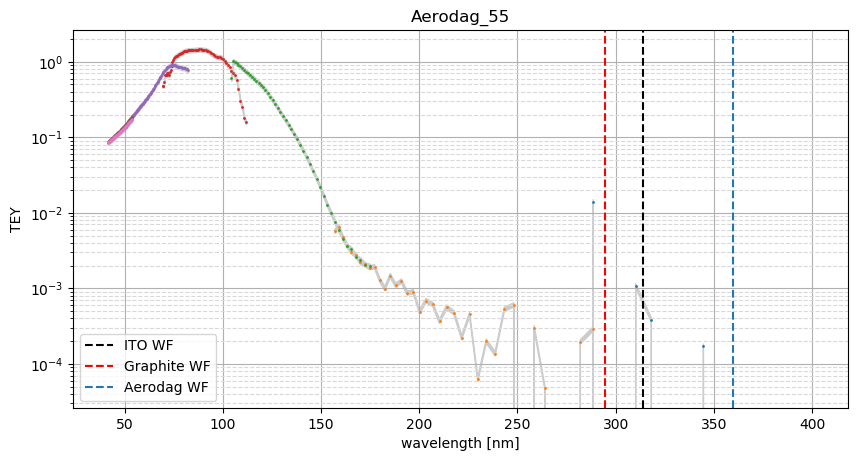

In [1018]:
figure(figsize=(10, 5), dpi=100)

for region_index in range(0, regs_per_sample):
    
    FIRST_FRAC = MATERIALS[material_index][region_index][4]
    FIRST_FRAC_ERR = MATERIALS[material_index][region_index][9]

    TEY_reg = [i * j * k for i,j,k in zip(FIRST_FRAC, SECOND_FRAC[region_index], FACTOR[region_index])]
    TEY_reg_err = [np.sqrt((dF1*F2*F3)**2 + (F1*dF2*F3)**2 + (F1*F2*dF3)**2) for F1,F2,F3,dF1,dF2,dF3 in zip(FIRST_FRAC,SECOND_FRAC[region_index],FACTOR[region_index],FIRST_FRAC_ERR, SECOND_FRAC_ERR[region_index],FACTOR_ERR[region_index])]

    phot_E_reg = MATERIALS[material_index][region_index][2]
    
    plt.fill_between(convert_eV_to_wavelength(phot_E_reg), [i-j for i,j in zip(TEY_reg,TEY_reg_err)], [i+j for i,j in zip(TEY_reg,TEY_reg_err)], color='0.8')
    plt.plot(convert_eV_to_wavelength(phot_E_reg), TEY_reg, marker, markersize=1)
    plt.yscale('log')
    plt.title(materials[material_index])

plt.xlabel('wavelength [nm]')
plt.ylabel('TEY')
plt.grid(linestyle='--')
plt.grid(which = 'major', linestyle='-')
plt.grid(which = 'minor', linestyle='--', color='0.85')
#plt.gca().set_ylim(top=1.5)

plt.axvline(x=convert_eV_to_wavelength([ITO_WF])[0], color='k', linestyle='--', label="ITO WF")
plt.axvline(x=convert_eV_to_wavelength([Graphite_WF])[0], color='r', linestyle='--', label="Graphite WF")
plt.axvline(x=convert_eV_to_wavelength([Aerodag_WF])[0], linestyle='--', label="Aerodag WF")
plt.legend(loc="lower left")

In [ ]:
#comment